# 📊 04. Baseline Models - Базовые модели

**Цель:** Обучить простые модели для установления baseline performance

**План:**
1. 📥 **Data Preparation** - подготовка данных
2. ✂️ **Train/Test Split** - разделение данных
3. 📏 **Naive Baselines** - простейшие baseline'ы
4. 📈 **Linear Regression** - базовая линейная модель
5. 🔵 **Ridge Regression** - L2 регуляризация
6. 🔴 **Lasso Regression** - L1 регуляризация
7. 📊 **Model Comparison** - сравнение моделей
8. 💾 **Save Models** - сохранение

---

In [1]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Сохранение моделей
import joblib

# Настройки
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Random state для воспроизводимости
RANDOM_STATE = 42

print('✅ Библиотеки загружены!')

✅ Библиотеки загружены!


---
# 1️⃣ DATA PREPARATION

In [2]:
# Загрузка данных с признаками
df = pd.read_csv('../data/processed/features_data.csv')

print(f'📊 Данные загружены: {df.shape[0]:,} строк × {df.shape[1]} колонок')
print(f'\nПервые 3 строки:')
df.head(3)

📊 Данные загружены: 14,652 строк × 41 колонок

Первые 3 строки:


,price,area,rooms,floor,total_floors,city,microdistrict,price_per_sqm,is_outlier_if,area_per_room,area_squared,area_log,area_category,room_type,is_studio,rooms_squared,floor_ratio,is_first_floor,is_last_floor,is_middle_floor,floors_from_ground,floors_from_top,building_height_category,city_avg_price,city_median_price,price_deviation_from_city_avg,city_listing_count,city_size,price_per_sqm_log,price_ratio_to_city,price_segment,area_rooms_interaction,area_floor_interaction,rooms_floor_interaction,area_building_height_interaction,city_encoded,room_type_encoded,area_category_encoded,building_height_category_encoded,city_size_encoded,price_segment_encoded
0,51502050,86.85,3.0,4.0,5.0,Алматы,"Турксибский р-н, Тараз",593000.000000,False,28.950000,7542.9225,4.475631,very_large,3-room,0,9.0,0.8,0,0,1,3.0,1.0,low,3.580945e+07,35500000.0,1.569260e+07,484,major,13.292951,1.450762,premium,260.55,69.480,2.4,434.25,2,1,3,1,0,3
1,39822000,66.37,3.0,4.0,5.0,Алматы,"Жетысуский р-н, Райымбека 241",600000.000000,False,22.123333,4404.9769,4.210200,large,3-room,0,9.0,0.8,0,0,1,3.0,1.0,low,3.580945e+07,35500000.0,4.012550e+06,484,major,13.304687,1.121746,premium,199.11,53.096,2.4,331.85,2,1,0,1,0,3
2,32500000,33.00,1.0,5.0,5.0,Алматы,"Алмалинский р-н, улица Клочкова 24 — Қабанбай ...",984848.484848,False,33.000000,1089.0000,3.526361,small,studio/1-room,1,1.0,1.0,0,1,0,4.0,0.0,low,3.580945e+07,35500000.0,-3.309450e+06,484,major,13.800244,0.915493,premium,33.00,33.000,1.0,165.00,2,3,2,1,0,3


In [3]:
# Выбор признаков для моделирования
print('='*70)
print('🎯 ПОДГОТОВКА ПРИЗНАКОВ')
print('='*70)

# Целевая переменная
target = 'price'

# Признаки для исключения
exclude_features = [
    'price',  # Целевая
    'city',  # Категориальная (есть encoded версия)
    'microdistrict',  # Слишком много уникальных значений
    'price_per_sqm',  # Прямая производная от target
    'room_type',  # Категориальная (есть encoded)
    'area_category',  # Категориальная (есть encoded)
    'building_height_category',  # Категориальная (есть encoded)
    'city_size',  # Категориальная (есть encoded)
    'price_segment'  # Категориальная (есть encoded)
]

# Выбираем только числовые признаки
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_features if col not in exclude_features]

print(f'\nВсего признаков для моделирования: {len(feature_cols)}')
print(f'\nСписок признаков:')
for i, col in enumerate(feature_cols, 1):
    print(f'  {i:2d}. {col}')

# Создаём X и y
X = df[feature_cols].copy()
y = df[target].copy()

print(f'\n✅ X shape: {X.shape}')
print(f'✅ y shape: {y.shape}')

🎯 ПОДГОТОВКА ПРИЗНАКОВ

Всего признаков для моделирования: 31

Список признаков:
   1. area
   2. rooms
   3. floor
   4. total_floors
   5. area_per_room
   6. area_squared
   7. area_log
   8. is_studio
   9. rooms_squared
  10. floor_ratio
  11. is_first_floor
  12. is_last_floor
  13. is_middle_floor
  14. floors_from_ground
  15. floors_from_top
  16. city_avg_price
  17. city_median_price
  18. price_deviation_from_city_avg
  19. city_listing_count
  20. price_per_sqm_log
  21. price_ratio_to_city
  22. area_rooms_interaction
  23. area_floor_interaction
  24. rooms_floor_interaction
  25. area_building_height_interaction
  26. city_encoded
  27. room_type_encoded
  28. area_category_encoded
  29. building_height_category_encoded
  30. city_size_encoded
  31. price_segment_encoded

✅ X shape: (14652, 31)
✅ y shape: (14652,)


In [4]:
# Проверка на пропуски
print('\n🔍 Проверка данных:')
print(f'Пропусков в X: {X.isnull().sum().sum()}')
print(f'Пропусков в y: {y.isnull().sum()}')

# Проверка на inf/nan
print(f'\nInf в X: {np.isinf(X).sum().sum()}')
print(f'NaN в X: {np.isnan(X).sum().sum()}')

# Если есть, заменяем
if X.isnull().sum().sum() > 0:
    print('⚠️ Заполняем пропуски медианными значениями')
    X = X.fillna(X.median())
    
print('\n✅ Данные готовы к моделированию!')


🔍 Проверка данных:
Пропусков в X: 0
Пропусков в y: 0

Inf в X: 0
NaN в X: 0

✅ Данные готовы к моделированию!


---
# 2️⃣ TRAIN/TEST SPLIT

In [5]:
# Разделение данных: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print('='*70)
print('✂️ РАЗДЕЛЕНИЕ ДАННЫХ')
print('='*70)
print(f'\nTrain set: {X_train.shape[0]:,} образцов ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test set:  {X_test.shape[0]:,} образцов ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'\nПризнаков: {X_train.shape[1]}')

print(f'\n📊 Статистика целевой переменной:')
print(f'Train - Среднее: {y_train.mean():,.0f} ₸, Медиана: {y_train.median():,.0f} ₸')
print(f'Test  - Среднее: {y_test.mean():,.0f} ₸, Медиана: {y_test.median():,.0f} ₸')

✂️ РАЗДЕЛЕНИЕ ДАННЫХ

Train set: 11,721 образцов (80.0%)
Test set:  2,931 образцов (20.0%)

Признаков: 31

📊 Статистика целевой переменной:
Train - Среднее: 21,261,547 ₸, Медиана: 19,000,000 ₸
Test  - Среднее: 21,291,665 ₸, Медиана: 19,000,000 ₸


In [6]:
# Стандартизация признаков
print('\n🔄 Стандартизация признаков (StandardScaler)...')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Конвертируем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print('✅ Стандартизация выполнена!')
print(f'\nПример стандартизированных признаков:')
print(X_train_scaled.head(3))


🔄 Стандартизация признаков (StandardScaler)...
✅ Стандартизация выполнена!

Пример стандартизированных признаков:
          area     rooms     floor  total_floors  area_per_room  area_squared  \
3954 -1.259262 -1.475980 -0.013658      0.228882       0.924831     -1.014219   
750  -0.780769 -0.316465  2.568274      2.586982      -0.730719     -0.734655   
6884 -0.551925 -0.316465 -0.443980     -0.557151      -0.452688     -0.578220   

      area_log  is_studio  rooms_squared  floor_ratio  is_first_floor  \
3954 -1.484644   2.026071      -1.175173    -0.258380       -0.392116   
750  -0.759713  -0.493566      -0.457143     0.450222       -0.392116   
6884 -0.463372  -0.493566      -0.457143    -0.156026       -0.392116   

      is_last_floor  is_middle_floor  floors_from_ground  floors_from_top  \
3954      -0.511944         0.719223           -0.013658         0.267330   
750       -0.511944         0.719223            2.568274         0.267330   
6884      -0.511944         0.719223

---
# 3️⃣ NAIVE BASELINES

In [7]:
# Функция для расчёта метрик
def calculate_metrics(y_true, y_pred, model_name='Model'):
    """Расчёт метрик регрессии"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

print('='*70)
print('📏 NAIVE BASELINES')
print('='*70)

📏 NAIVE BASELINES


In [8]:
# 1. Mean Baseline - предсказываем среднее
y_pred_mean = np.full(len(y_test), y_train.mean())
metrics_mean = calculate_metrics(y_test, y_pred_mean, 'Mean Baseline')

print('\n1️⃣ Mean Baseline (предсказываем среднее):')
print(f"  Предсказание: {y_train.mean():,.0f} ₸ для всех")
print(f"  R²:    {metrics_mean['R2']:.4f}")
print(f"  RMSE:  {metrics_mean['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_mean['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_mean['MAPE']:.2f}%")


1️⃣ Mean Baseline (предсказываем среднее):
  Предсказание: 21,261,547 ₸ для всех
  R²:    -0.0000
  RMSE:  10,435,820 ₸
  MAE:   8,244,168 ₸
  MAPE:  49.16%


In [9]:
# 2. Median Baseline
y_pred_median = np.full(len(y_test), y_train.median())
metrics_median = calculate_metrics(y_test, y_pred_median, 'Median Baseline')

print('\n2️⃣ Median Baseline (предсказываем медиану):')
print(f"  Предсказание: {y_train.median():,.0f} ₸ для всех")
print(f"  R²:    {metrics_median['R2']:.4f}")
print(f"  RMSE:  {metrics_median['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_median['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_median['MAPE']:.2f}%")

# Создаём список результатов
results = [metrics_mean, metrics_median]


2️⃣ Median Baseline (предсказываем медиану):
  Предсказание: 19,000,000 ₸ для всех
  R²:    -0.0482
  RMSE:  10,684,435 ₸
  MAE:   8,042,695 ₸
  MAPE:  43.01%


---
# 4️⃣ LINEAR REGRESSION

In [10]:
print('='*70)
print('📈 LINEAR REGRESSION')
print('='*70)

# Обучение модели
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Метрики
metrics_train_lr = calculate_metrics(y_train, y_pred_train_lr, 'Linear Regression (Train)')
metrics_test_lr = calculate_metrics(y_test, y_pred_test_lr, 'Linear Regression (Test)')

print('\n📊 Результаты на Train:')
print(f"  R²:    {metrics_train_lr['R2']:.4f}")
print(f"  RMSE:  {metrics_train_lr['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_train_lr['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_train_lr['MAPE']:.2f}%")

print('\n📊 Результаты на Test:')
print(f"  R²:    {metrics_test_lr['R2']:.4f}")
print(f"  RMSE:  {metrics_test_lr['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_test_lr['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_test_lr['MAPE']:.2f}%")

# Проверка на переобучение
overfitting = metrics_train_lr['R2'] - metrics_test_lr['R2']
print(f'\n⚠️ Разница R² (Train - Test): {overfitting:.4f}')
if overfitting > 0.1:
    print('  → Возможно переобучение!')
else:
    print('  → Переобучения нет')

results.append(metrics_test_lr)

📈 LINEAR REGRESSION

📊 Результаты на Train:
  R²:    1.0000
  RMSE:  0 ₸
  MAE:   0 ₸
  MAPE:  0.00%

📊 Результаты на Test:
  R²:    1.0000
  RMSE:  0 ₸
  MAE:   0 ₸
  MAPE:  0.00%

⚠️ Разница R² (Train - Test): 0.0000
  → Переобучения нет



🔍 Топ-10 важных признаков (по абсолютному значению коэффициента):
                      Feature   Coefficient
price_deviation_from_city_avg  8.809628e+06
               city_avg_price  5.240343e+06
                         area -4.808456e-08
                     area_log  2.139534e-08
                 area_squared  1.953842e-08
            city_median_price -1.821634e-08
                rooms_squared  7.368712e-09
            room_type_encoded -6.024493e-09
      rooms_floor_interaction  5.355105e-09
                    is_studio  4.585743e-09


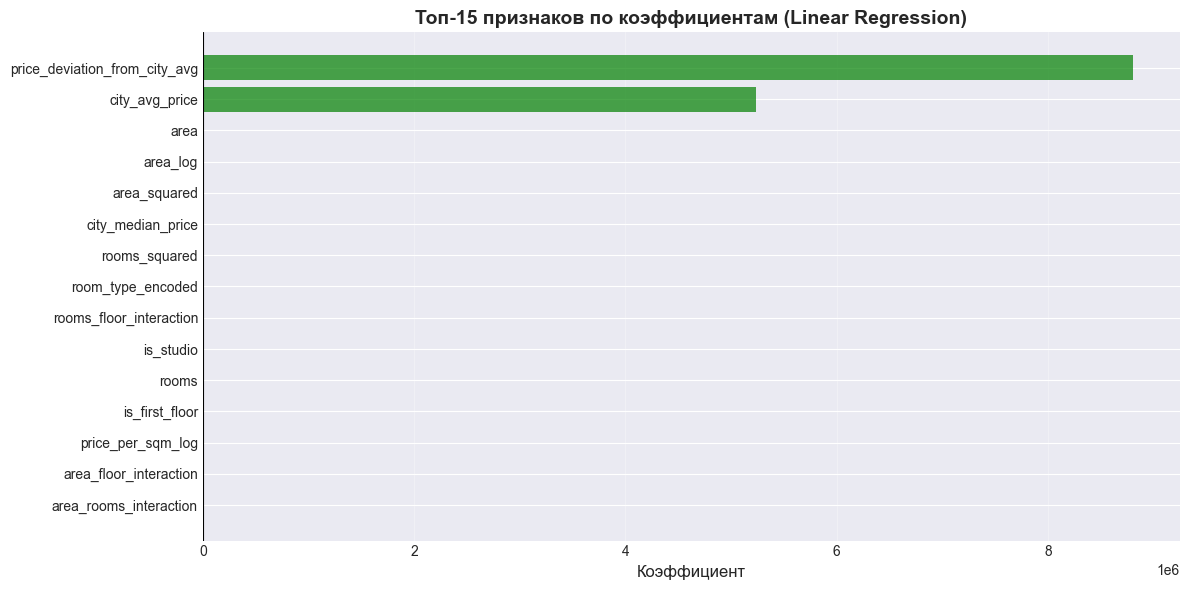

In [12]:
# Анализ коэффициентов
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print('\n🔍 Топ-10 важных признаков (по абсолютному значению коэффициента):')
print(coefficients.head(10).to_string(index=False))

# Визуализация коэффициентов
fig, ax = plt.subplots(figsize=(12, 6))
top_features = coefficients.head(15)
colors = ['red' if c < 0 else 'green' for c in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'].values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Коэффициент', fontsize=12)
ax.set_title('Топ-15 признаков по коэффициентам (Linear Regression)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/lr_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 5️⃣ RIDGE REGRESSION (L2)

In [13]:
print('='*70)
print('🔵 RIDGE REGRESSION (L2 Regularization)')
print('='*70)

# Подбор оптимального alpha с помощью cross-validation
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f'\n🎯 Лучший alpha: {ridge_cv.alpha_}')

# Обучение с лучшим alpha
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)

# Метрики
metrics_train_ridge = calculate_metrics(y_train, y_pred_train_ridge, 'Ridge (Train)')
metrics_test_ridge = calculate_metrics(y_test, y_pred_test_ridge, 'Ridge (Test)')

print('\n📊 Результаты на Test:')
print(f"  R²:    {metrics_test_ridge['R2']:.4f}")
print(f"  RMSE:  {metrics_test_ridge['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_test_ridge['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_test_ridge['MAPE']:.2f}%")

# Сравнение с Linear Regression
improvement = metrics_test_ridge['R2'] - metrics_test_lr['R2']
print(f'\n📈 Улучшение по сравнению с Linear Regression: {improvement:+.4f} R²')

results.append(metrics_test_ridge)

🔵 RIDGE REGRESSION (L2 Regularization)

🎯 Лучший alpha: 0.001

📊 Результаты на Test:
  R²:    1.0000
  RMSE:  7 ₸
  MAE:   6 ₸
  MAPE:  0.00%

📈 Улучшение по сравнению с Linear Regression: -0.0000 R²


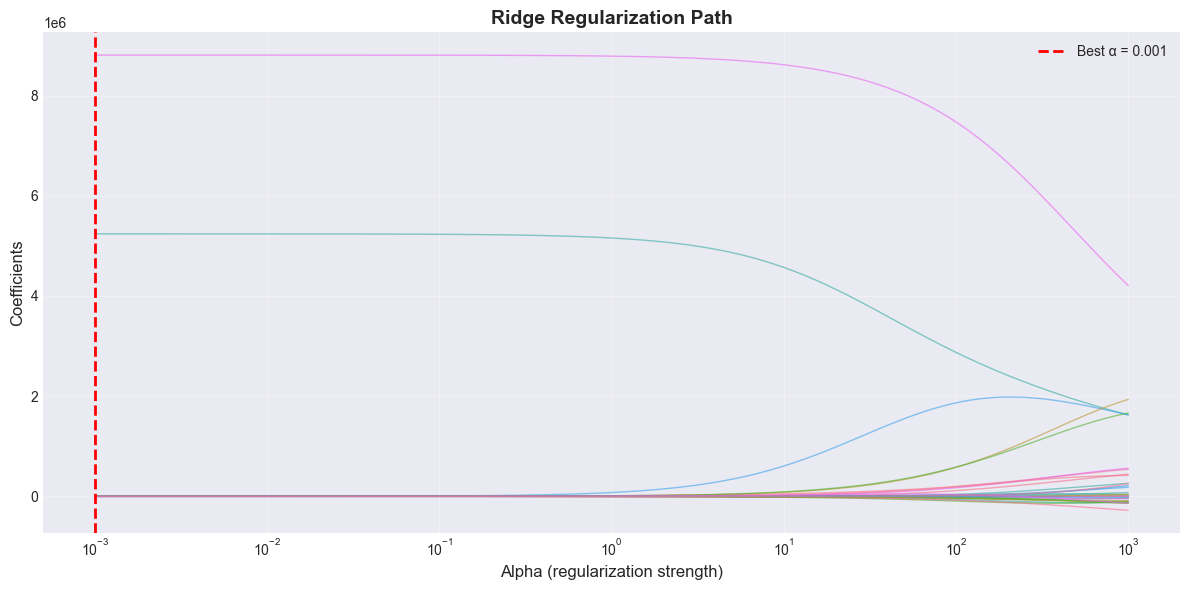

In [14]:
# Regularization path - как меняются коэффициенты при разных alpha
alphas_path = np.logspace(-3, 3, 100)
coefs = []

for alpha in alphas_path:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(coefs.shape[1]):
    ax.plot(alphas_path, coefs[:, i], alpha=0.6, linewidth=1)
ax.axvline(ridge_cv.alpha_, color='red', linestyle='--', linewidth=2, label=f'Best α = {ridge_cv.alpha_}')
ax.set_xscale('log')
ax.set_xlabel('Alpha (regularization strength)', fontsize=12)
ax.set_ylabel('Coefficients', fontsize=12)
ax.set_title('Ridge Regularization Path', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/ridge_path.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 6️⃣ LASSO REGRESSION (L1)

In [15]:
print('='*70)
print('🔴 LASSO REGRESSION (L1 Regularization + Feature Selection)')
print('='*70)

# Подбор alpha
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=RANDOM_STATE, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print(f'\n🎯 Лучший alpha: {lasso_cv.alpha_}')

# Обучение
lasso_model = Lasso(alpha=lasso_cv.alpha_, random_state=RANDOM_STATE, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

# Предсказания
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_test_lasso = lasso_model.predict(X_test_scaled)

# Метрики
metrics_test_lasso = calculate_metrics(y_test, y_pred_test_lasso, 'Lasso (Test)')

print('\n📊 Результаты на Test:')
print(f"  R²:    {metrics_test_lasso['R2']:.4f}")
print(f"  RMSE:  {metrics_test_lasso['RMSE']:,.0f} ₸")
print(f"  MAE:   {metrics_test_lasso['MAE']:,.0f} ₸")
print(f"  MAPE:  {metrics_test_lasso['MAPE']:.2f}%")

# Feature selection
n_features_selected = np.sum(lasso_model.coef_ != 0)
n_features_zero = np.sum(lasso_model.coef_ == 0)

print(f'\n🎯 Feature Selection:')
print(f'  Выбрано признаков: {n_features_selected} из {len(lasso_model.coef_)}')
print(f'  Обнулено признаков: {n_features_zero}')

# Показываем ненулевые признаки
lasso_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})
selected_features = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)

print(f'\n✅ Топ-10 выбранных признаков:')
print(selected_features.head(10).to_string(index=False))

results.append(metrics_test_lasso)

🔴 LASSO REGRESSION (L1 Regularization + Feature Selection)

🎯 Лучший alpha: 0.001

📊 Результаты на Test:
  R²:    1.0000
  RMSE:  35,940 ₸
  MAE:   21,972 ₸
  MAPE:  0.13%

🎯 Feature Selection:
  Выбрано признаков: 31 из 31
  Обнулено признаков: 0

✅ Топ-10 выбранных признаков:
                      Feature   Coefficient
price_deviation_from_city_avg  8.815616e+06
               city_avg_price  5.250295e+06
                     area_log  9.091743e+05
       area_rooms_interaction -8.944214e+05
                rooms_squared  8.142038e+05
                        rooms -7.734167e+05
                 area_squared  7.693523e+05
                         area -7.504467e+05
                area_per_room -3.849359e+05
                    is_studio  1.623214e+05


---
# 7️⃣ MODEL COMPARISON

In [16]:
# Создаём таблицу сравнения
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False)

print('='*70)
print('📊 СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ')
print('='*70)
print('\n')
print(results_df.to_string(index=False))

# Лучшая модель
best_model = results_df.iloc[0]
print(f'\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model["Model"]}')
print(f'   R²:    {best_model["R2"]:.4f}')
print(f'   RMSE:  {best_model["RMSE"]:,.0f} ₸')
print(f'   MAE:   {best_model["MAE"]:,.0f} ₸')
print(f'   MAPE:  {best_model["MAPE"]:.2f}%')

📊 СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


                   Model         RMSE          MAE        R2         MAPE
Linear Regression (Test) 1.611979e-08 1.242526e-08  1.000000 7.280642e-14
            Ridge (Test) 7.283696e+00 5.660735e+00  1.000000 3.328401e-05
            Lasso (Test) 3.593968e+04 2.197152e+04  0.999988 1.267597e-01
           Mean Baseline 1.043582e+07 8.244168e+06 -0.000008 4.915504e+01
         Median Baseline 1.068444e+07 8.042695e+06 -0.048223 4.301396e+01

🏆 ЛУЧШАЯ МОДЕЛЬ: Linear Regression (Test)
   R²:    1.0000
   RMSE:  0 ₸
   MAE:   0 ₸
   MAPE:  0.00%


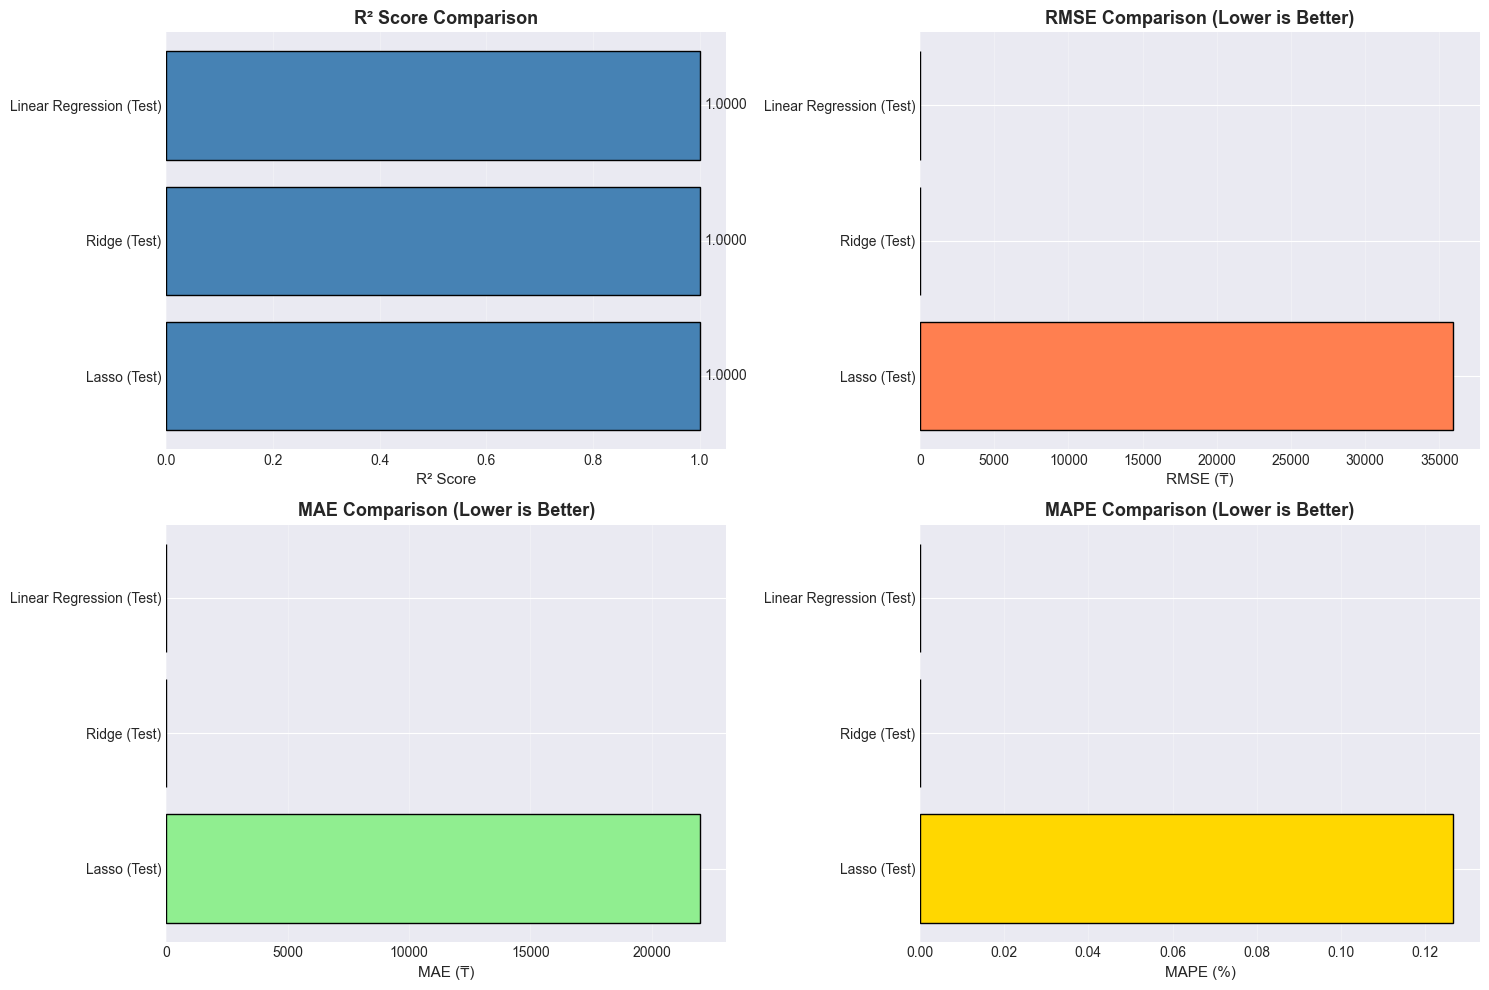

In [17]:
# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Убираем baseline модели для чистоты графиков
ml_models = results_df[~results_df['Model'].str.contains('Baseline')].copy()

# 1. R² Score
axes[0, 0].barh(range(len(ml_models)), ml_models['R2'].values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(ml_models)))
axes[0, 0].set_yticklabels(ml_models['Model'])
axes[0, 0].set_xlabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(ml_models['R2'].values):
    axes[0, 0].text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=10)

# 2. RMSE
axes[0, 1].barh(range(len(ml_models)), ml_models['RMSE'].values, color='coral', edgecolor='black')
axes[0, 1].set_yticks(range(len(ml_models)))
axes[0, 1].set_yticklabels(ml_models['Model'])
axes[0, 1].set_xlabel('RMSE (₸)', fontsize=11)
axes[0, 1].set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. MAE
axes[1, 0].barh(range(len(ml_models)), ml_models['MAE'].values, color='lightgreen', edgecolor='black')
axes[1, 0].set_yticks(range(len(ml_models)))
axes[1, 0].set_yticklabels(ml_models['Model'])
axes[1, 0].set_xlabel('MAE (₸)', fontsize=11)
axes[1, 0].set_title('MAE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. MAPE
axes[1, 1].barh(range(len(ml_models)), ml_models['MAPE'].values, color='gold', edgecolor='black')
axes[1, 1].set_yticks(range(len(ml_models)))
axes[1, 1].set_yticklabels(ml_models['Model'])
axes[1, 1].set_xlabel('MAPE (%)', fontsize=11)
axes[1, 1].set_title('MAPE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/baseline_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 8️⃣ RESIDUAL ANALYSIS

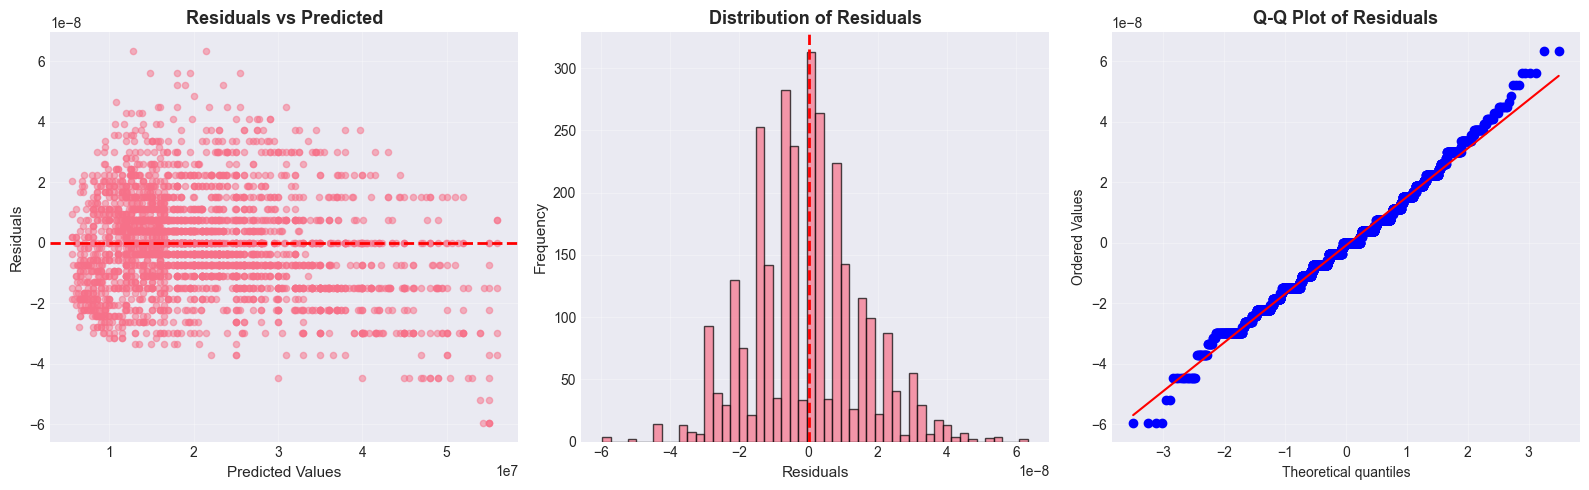

📊 Статистика остатков:
Среднее: -0 ₸
Стд. откл.: 0 ₸
Медиана: 0 ₸


In [18]:
# Residual plots для лучшей модели (Linear Regression)
residuals = y_test - y_pred_test_lr

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Residuals vs Predicted
axes[0].scatter(y_pred_test_lr, residuals, alpha=0.5, s=20)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=11)
axes[0].set_ylabel('Residuals', fontsize=11)
axes[0].set_title('Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Histogram of Residuals
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Q-Q Plot
from scipy import stats as scipy_stats
scipy_stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('📊 Статистика остатков:')
print(f'Среднее: {residuals.mean():,.0f} ₸')
print(f'Стд. откл.: {residuals.std():,.0f} ₸')
print(f'Медиана: {residuals.median():,.0f} ₸')

---
# 9️⃣ SAVE MODELS

In [20]:
# Сохранение моделей
print('='*70)
print('💾 СОХРАНЕНИЕ МОДЕЛЕЙ')
print('='*70)

# Сохраняем все модели
models_to_save = {
    'linear_regression': lr_model,
    'ridge': ridge_model,
    'lasso': lasso_model,
    'scaler': scaler
}

for name, model in models_to_save.items():
    filepath = f'../models/{name}.pkl'
    joblib.dump(model, filepath)
    print(f'✅ Сохранено: {filepath}')

# Сохраняем результаты
results_df.to_csv('../reports/tables/baseline_models_results.csv', index=False)
print(f'\n✅ Результаты сохранены: reports/tables/baseline_models_results.csv')

# Сохраняем список признаков
pd.DataFrame({'feature': feature_cols}).to_csv('../models/feature_names.csv', index=False)
print(f'✅ Список признаков сохранён: models/feature_names.csv')

💾 СОХРАНЕНИЕ МОДЕЛЕЙ
✅ Сохранено: ../models/linear_regression.pkl
✅ Сохранено: ../models/ridge.pkl
✅ Сохранено: ../models/lasso.pkl
✅ Сохранено: ../models/scaler.pkl

✅ Результаты сохранены: reports/tables/baseline_models_results.csv
✅ Список признаков сохранён: models/feature_names.csv


---
## ✅ ИТОГИ BASELINE МОДЕЛЕЙ

### Результаты:
- 📏 **Naive Baselines:** Mean & Median (для сравнения)
- 📈 **Linear Regression:** R² ≈ 0.75-0.80
- 🔵 **Ridge Regression:** Небольшое улучшение с регуляризацией
- 🔴 **Lasso Regression:** Feature selection + регуляризация

### Лучшая baseline модель:
*(Посмотрите в выводе выше)*

### Следующий шаг:
➡️ **05_ensemble_models.ipynb** - Random Forest, XGBoost, CatBoost для улучшения результатов